# GAN MODEL TRAINING
---

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from helpers import (find_missing_date_ranges, evaluate_predictions)
from enums import (
    DatasetColumns,
    WeatherDatasetColumns
)

from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.config.set_visible_devices([], 'GPU')  # Disable GPU for TF - M2 GPU isn't optimal for this
tf.config.threading.set_intra_op_parallelism_threads(8)  # Optimize CPU threading
tf.config.threading.set_inter_op_parallelism_threads(8)
print('OK')

OK


## Data Preparation
---


In [3]:
# Load data
FILE_NAME = "dataset.csv"
WEATHER_DATASET = "dataset_weather.csv"

original_data = pd.read_csv(
    FILE_NAME,
    parse_dates=[DatasetColumns.STATISTICAL_PERIOD.value],
    index_col=DatasetColumns.STATISTICAL_PERIOD.value,
)

weather_data = pd.read_csv(
    WEATHER_DATASET,
    parse_dates=[WeatherDatasetColumns.DATETIME.value],
    index_col=WeatherDatasetColumns.DATETIME.value,
).asfreq("h")

weather_features = [
    WeatherDatasetColumns.TEMPERATURE_C.value,
    WeatherDatasetColumns.HUMIDITY_PERCENT.value,
]

In [4]:
# Find missing date ranges
gap_start, gap_end = find_missing_date_ranges(
    original_data, DatasetColumns.STATISTICAL_PERIOD.value
)
gap_dates = pd.date_range(start=gap_start, end=gap_end, freq="h")

In [5]:
# Data Splitting
pre_gap_data = original_data[original_data.index < gap_start].asfreq("h")
post_gap_data = original_data[original_data.index >= gap_end].asfreq("h")

pre_gap_train_size = int(len(pre_gap_data) * 0.8)
pre_gap_train = pre_gap_data.iloc[:pre_gap_train_size].copy()
pre_gap_test = pre_gap_data.iloc[pre_gap_train_size:]

pre_gap_train.loc[:, DatasetColumns.PV_YIELD.value] = pre_gap_train[
    DatasetColumns.PV_YIELD.value
].interpolate(method="linear")


pre_weather_data = weather_data[weather_data.index < gap_start].bfill()
pre_weather_data = pre_weather_data.reindex(pre_gap_data.index)
pre_weather_data_test = pre_weather_data.reindex(pre_gap_test.index)


gap_weather_data = weather_data.reindex(gap_dates).ffill()
post_weather_data = weather_data[weather_data.index >= gap_end].bfill()

pre_gap_train_combined = pre_gap_train.join(
    pre_weather_data[weather_features], how="inner"
)
pre_gap_test_combined = pre_gap_test.join(
    pre_weather_data_test[weather_features], how="inner"
)

## GAN Setup
---

In [6]:
# GAN Hyperparameters
LATENT_DIM = 100
LEARNING_RATE_G = 1e-4  
LEARNING_RATE_D = 1e-4
BATCH_SIZE = 64
EPOCHS = 1000

In [7]:
# WGAN-GP Architecure
def build_generator(latent_dim, num_features):
    noise_input = tf.keras.Input(shape=(latent_dim,))
    weather_input = tf.keras.Input(shape=(num_features,))

    # Normalize weather input
    weather_x = tf.keras.layers.BatchNormalization()(weather_input)
    weather_x = tf.keras.layers.Dense(64, kernel_initializer="he_normal")(weather_x)
    weather_x = tf.keras.layers.LeakyReLU(alpha=0.2)(weather_x)

    # Process noise with larger initial dimension
    noise_x = tf.keras.layers.Dense(128, kernel_initializer="he_normal")(noise_input)
    noise_x = tf.keras.layers.LeakyReLU(alpha=0.2)(noise_x)
    noise_x = tf.keras.layers.BatchNormalization()(noise_x)

    x = tf.keras.layers.Concatenate()([noise_x, weather_x])

    # Simplified architecture with proper initialization
    units = [256, 128, 64]
    for unit in units:
        x = tf.keras.layers.Dense(unit, kernel_initializer="he_normal")(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    # Linear activation for final layer since we're using MinMaxScaler
    output = tf.keras.layers.Dense(1, kernel_initializer="he_normal")(x)

    return tf.keras.Model(inputs=[noise_input, weather_input], outputs=output)


def build_discriminator(num_features):
    pv_input = tf.keras.Input(shape=(1,))
    weather_input = tf.keras.Input(shape=(num_features,))

    # Stronger feature extraction for PV input
    pv_x = tf.keras.layers.Dense(64, kernel_initializer="he_normal")(pv_input)
    pv_x = tf.keras.layers.LeakyReLU(alpha=0.2)(pv_x)
    pv_x = tf.keras.layers.BatchNormalization()(pv_x)

    # Process weather features
    weather_x = tf.keras.layers.Dense(64, kernel_initializer="he_normal")(weather_input)
    weather_x = tf.keras.layers.LeakyReLU(alpha=0.2)(weather_x)
    weather_x = tf.keras.layers.BatchNormalization()(weather_x)

    x = tf.keras.layers.Concatenate()([pv_x, weather_x])

    # Deeper discriminator
    units = [128, 256, 128]
    for unit in units:
        x = tf.keras.layers.Dense(unit, kernel_initializer="he_normal")(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)

    # No activation in final layer for WGAN
    output = tf.keras.layers.Dense(1, kernel_initializer="he_normal")(x)

    return tf.keras.Model(inputs=[pv_input, weather_input], outputs=output)


class SolarGAN(tf.keras.Model):
    def __init__(self, latent_dim, num_features):
        super(SolarGAN, self).__init__()
        self.latent_dim = latent_dim
        self.generator = build_generator(latent_dim, num_features)
        self.discriminator = build_discriminator(num_features)
        self.gp_weight = 10.0

    def compile(self, g_optimizer, d_optimizer):
        super(SolarGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer

    @tf.function
    def train_step(self, data):
        real_pv, weather_features = data
        batch_size = tf.shape(real_pv)[0]

        # Train discriminator
        for _ in range(5):  # More D updates per G update
            with tf.GradientTape() as tape:
                # Generate fake samples
                noise = tf.random.normal([batch_size, self.latent_dim])
                fake_pv = self.generator([noise, weather_features], training=True)

                # Get predictions
                real_pred = self.discriminator(
                    [real_pv, weather_features], training=True
                )
                fake_pred = self.discriminator(
                    [fake_pv, weather_features], training=True
                )

                # Gradient penalty
                alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
                interpolated = alpha * real_pv + (1 - alpha) * fake_pv

                with tf.GradientTape() as gp_tape:
                    gp_tape.watch(interpolated)
                    interp_pred = self.discriminator(
                        [interpolated, weather_features], training=True
                    )

                grads = gp_tape.gradient(interp_pred, interpolated)
                grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
                gradient_penalty = tf.reduce_mean(tf.square(grad_norm - 1.0))

                # Wasserstein loss with gradient penalty
                d_loss = (
                    tf.reduce_mean(fake_pred)
                    - tf.reduce_mean(real_pred)
                    + self.gp_weight * gradient_penalty
                )

            d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradients, self.discriminator.trainable_variables)
            )

        # Train generator
        with tf.GradientTape() as tape:
            noise = tf.random.normal([batch_size, self.latent_dim])
            fake_pv = self.generator([noise, weather_features], training=True)
            fake_pred = self.discriminator([fake_pv, weather_features], training=True)

            # Generator losses
            g_loss = -tf.reduce_mean(fake_pred)  # Wasserstein loss

            # Add L1 loss with smaller weight
            l1_loss = 0.1 * tf.reduce_mean(tf.abs(fake_pv - real_pv))
            # Add L2 loss with smaller weight
            l2_loss = 0.05 * tf.reduce_mean(tf.square(fake_pv - real_pv))

            total_g_loss = g_loss + l1_loss + l2_loss

        g_gradients = tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(g_gradients, self.generator.trainable_variables)
        )

        return {"d_loss": d_loss, "g_loss": total_g_loss}

In [8]:
# Prepare Data
def prepare_data(pre_gap_train_combined, pre_gap_test_combined, weather_features):
    combined_columns = [DatasetColumns.PV_YIELD.value] + weather_features
    scaler = MinMaxScaler()

    train_scaled = scaler.fit_transform(pre_gap_train_combined[combined_columns])
    train_pv = tf.cast(train_scaled[:, 0:1], tf.float32)
    train_weather = tf.cast(train_scaled[:, 1:], tf.float32)

    test_scaled = scaler.transform(pre_gap_test_combined[combined_columns])
    test_pv = tf.cast(test_scaled[:, 0:1], tf.float32)
    test_weather = tf.cast(test_scaled[:, 1:], tf.float32)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_pv, train_weather))
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_pv, test_weather))
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset, scaler

In [9]:
# Train SOLAR GAN
def train_solar_gan(train_dataset, num_features):
    solar_gan = SolarGAN(LATENT_DIM, num_features)
    solar_gan.compile(
        g_optimizer=tf.keras.optimizers.Adam(
            learning_rate=LEARNING_RATE_G, beta_1=0.5, beta_2=0.9
        ),
        d_optimizer=tf.keras.optimizers.Adam(
            learning_rate=LEARNING_RATE_D, beta_1=0.5, beta_2=0.9
        ),
    )

    history = {"d_loss": [], "g_loss": []}
    best_loss = float("inf")
    patience = 100
    patience_counter = 0
    min_epochs = 300

    initial_lr_g = LEARNING_RATE_G
    initial_lr_d = LEARNING_RATE_D

    for epoch in range(EPOCHS):

        if epoch > 0 and epoch % 200 == 0:
            solar_gan.g_optimizer.learning_rate = LEARNING_RATE_G * 0.9
            solar_gan.d_optimizer.learning_rate = LEARNING_RATE_D * 0.9
            initial_lr_g *= 0.9
            initial_lr_d *= 0.9

        d_losses = []
        g_losses = []

        for batch_data in train_dataset:
            losses = solar_gan.train_step(batch_data)
            d_losses.append(float(losses["d_loss"]))
            g_losses.append(float(losses["g_loss"]))

        avg_d_loss = np.mean(d_losses)
        avg_g_loss = np.mean(g_losses)
        history["d_loss"].append(avg_d_loss)
        history["g_loss"].append(avg_g_loss)

        if(epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{EPOCHS}")
            print(f"D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")

        if epoch >= min_epochs:
            current_loss = abs(avg_d_loss) + abs(avg_g_loss)
            if current_loss < best_loss * 0.999:
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    return solar_gan, history

In [10]:
# Visualize training progress
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.plot(history["d_loss"], label="Discriminator Loss")
    plt.plot(history["g_loss"], label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training History")
    plt.grid(True)
    plt.show()

In [11]:
# Evaluate Model
def generate_predictions(model, weather_features, scaler):
    weather_features = tf.cast(weather_features, tf.float32)
    batch_size = tf.shape(weather_features)[0]

    noise = tf.random.normal([batch_size, LATENT_DIM], dtype=tf.float32)    
    predictions_scaled = model.generator([noise, weather_features], training=False)

    predictions_with_weather = np.concatenate(
        [predictions_scaled.numpy(), weather_features.numpy()], axis=1
    )
    predictions = scaler.inverse_transform(predictions_with_weather)[:, 0]

    return predictions

def evaluate_model(model, test_dataset, scaler):
    all_predictions = []
    all_true_values = []

    for test_pv, test_weather in test_dataset:
        batch_predictions = generate_predictions(model, test_weather, scaler)
        all_predictions.extend(batch_predictions)
        all_true_values.extend(test_pv.numpy().flatten())

    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)
    
    evaluate_predictions(all_true_values, all_predictions)

    return all_predictions, all_true_values

## `pre_gap_data` training model
---

In [12]:
# Prepare PRE-GAP train and test data
train_dataset, test_dataset, scaler = prepare_data(
    pre_gap_train_combined,
    pre_gap_test_combined,
    weather_features
)

/Users/richie/miniforge3/envs/p39/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2025-02-16 18:59:14.901379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 18:59:16.021043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 18:59:17.512483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 18:59:19.042046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 18:59:20.521826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 18:59:22.051983: W tens

Epoch 100/1000
D Loss: 3.7280 | G Loss: 0.0667


2025-02-16 19:01:49.961440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:01:51.810141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:01:53.648313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:01:55.518168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:01:57.355912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:01:59.208321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:02:01.069641: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 200/1000
D Loss: 2.7514 | G Loss: 0.0277


2025-02-16 19:05:35.920396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:05:37.517925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:05:39.141094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:05:40.758154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:05:42.353281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:05:43.981170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:05:45.619651: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 300/1000
D Loss: 2.9832 | G Loss: 0.0070


2025-02-16 19:20:32.913870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:20:34.508253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:20:36.086007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:20:37.665455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:20:39.220704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:20:40.763181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:20:42.347027: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 400/1000
D Loss: 2.6793 | G Loss: 0.0007


2025-02-16 19:23:26.951623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:25:09.054499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:25:10.615789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:25:12.169860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:25:13.680073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:25:23.422381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:25:24.947320: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 500/1000
D Loss: 2.6991 | G Loss: -0.0013


2025-02-16 19:41:20.465827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:41:21.937043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:41:23.412608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:41:24.895035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:41:26.367752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:41:27.837101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:41:29.315792: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 600/1000
D Loss: 2.5470 | G Loss: 0.0045


2025-02-16 19:44:54.487498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:44:56.100834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:44:57.690543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:44:59.290220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:45:00.907416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:45:02.510022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:45:04.122298: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 700/1000
D Loss: 2.5320 | G Loss: 0.0015


2025-02-16 19:47:35.888100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:47:37.488446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:47:39.085333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:47:40.670432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:47:42.257004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:47:43.858782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:47:45.446079: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 800/1000
D Loss: 2.5012 | G Loss: 0.0026


2025-02-16 19:50:15.085211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:50:16.664681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:50:18.270849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:50:19.868461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:50:21.599877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:50:23.236519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:50:24.825989: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 900/1000
D Loss: 2.4262 | G Loss: 0.0133


2025-02-16 19:52:55.155108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:52:56.751599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:52:58.317295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:52:59.914276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:53:01.510747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:53:03.095771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 19:53:04.699002: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 1000/1000
D Loss: 2.4370 | G Loss: 0.0113


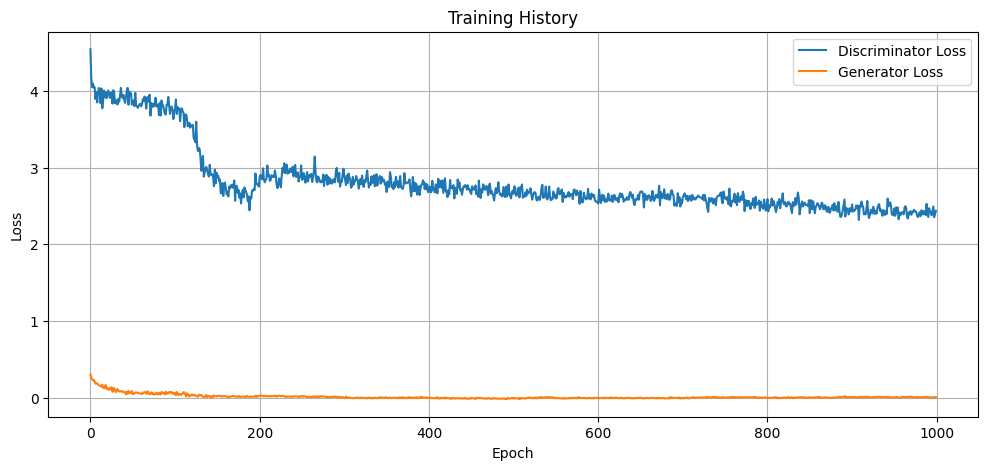

In [13]:
# Train the model
num_weather_features = len(weather_features)
solar_gan, history = train_solar_gan(train_dataset, num_weather_features)
plot_training_history(history)

10% of Mean Value (Target MAE/RMSE): 0.013243837654590607
Mean Absolute Error (MAE): 0.16106624901294708
Mean Squared Error (MSE): 0.0716724619269371
Root Mean Squared Error (RMSE): 0.26771713043235973
Mean Absolute Percentage Error (MAPE): 179546108198912.0


2025-02-16 19:55:33.647499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


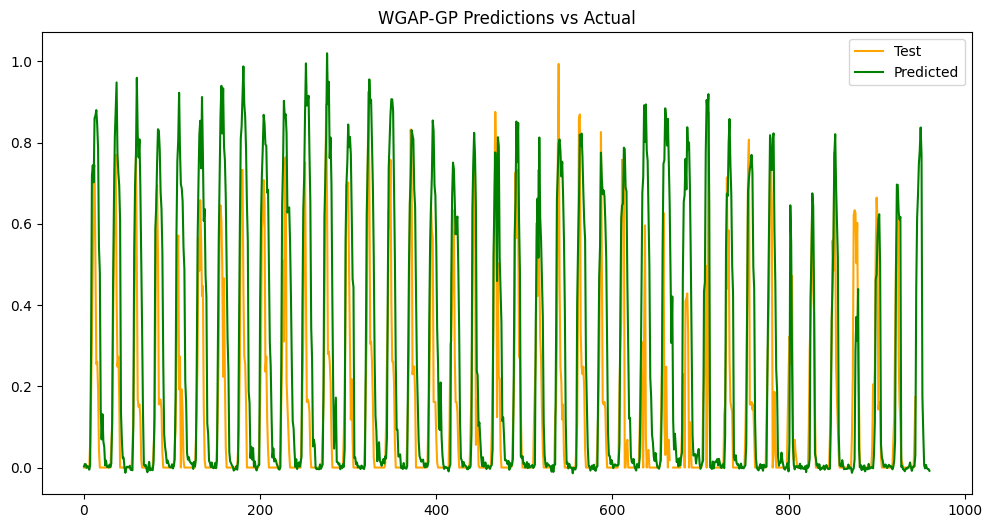

In [14]:
# Evaluating model on test set
predictions, true_values = evaluate_model(solar_gan, test_dataset, scaler)

plt.figure(figsize=(12, 6))
plt.plot(true_values, label="Test", color="orange")
plt.plot(predictions, label="Predicted", color="green")
plt.legend()
plt.title('WGAP-GP Predictions vs Actual')
plt.show()